In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import matplotlib

matplotlib.rcParams.update({'font.size': 16})

In [2]:
def comp_rho_p(x, p=0.5):
    '''
    params:
        x : np.array, [N,]
    return:
        res: np.array, [N, N], digonal matix
    '''
    
    N = x.shape[0]
    
    c1 = p + np.abs(x)
    c2 = np.log(1 + 1/p)
    res = 1 / (c1 * c2)
    res = np.diag(res)
    return res

In [3]:
def loss_fn(X, w, b):
    '''
    params:
        X: np.array, [T, N]
        w: np.array, [N,]
        b: np.array, [T ]

    return:
        obj: np.array, [T, 1]
    '''
        
    T = X.shape[0]
    
#     print(X.shape, w.shape, b.shape)
    
    loss = cp.norm(X @ w - b, 2) ** 2
    obj = loss / T
    
    return obj

def reg_fn(w, D, lambd=0.5):
    
    '''
    params:
        w: np.array, [N,]
        lambd: hyper-paramer
    return:
        w: np.array, [N, 1]
    '''
    
    l1 = cp.norm1(D @ w)
    obj = lambd * l1
    
    return obj

def objective_fn(X, w, b, D, lambd):
    
    l2_term = loss_fn(X, w, b)
    l1_term = reg_fn(w, D, lambd)
    
    return l2_term + l1_term

In [4]:
def solve_quadratic_program(X, x_true, D, lambd):
    '''
    params:
        X: np.array, [T, N]
        w: np.array, [N, 1]
        b: np.array, [T, 1]
        D: np.array, [N, N]
    
    return:
        w: np.array, [N, 1]
    '''
    
    
    
    T, N = X.shape
    
    w = cp.Variable(N)
    one_vec = np.ones(N)
    
    h = np.ones(1)
    b = np.zeros(N)
    lambd_ = cp.Parameter(nonneg=True)
    lambd_.value = lambd
    
    problem = cp.Problem(cp.Minimize(objective_fn(X, w, x_true, D, lambd)), 
                        [one_vec @ w == h,
                         w >= b])
    problem.solve()
    res = w.value
    
    return res

In [5]:
def LAIT_algo_optim(X, y, num_iter=50, p=0.5, lambd=0.0002):
    '''
    params:
        X: np.array, matrix of stock returns, size: [T, N], where N: number of stocks, T: the number of timesteps
        y: np.array, matrix of index returns, size: [T, ]
    
    return:
        w_star: [N, ], weights of stocks
    '''
    
    N = X.shape[1]
    w_init = np.random.randn(N)
    w_init = w_init / np.sum(w_init)
    
    w_k = w_init
    for i in range(0, num_iter):
        D = comp_rho_p(w_k, p=p)
        w_k = solve_quadratic_program(X, y, D, lambd=lambd)
        
    return w_k

In [6]:
company_table = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[4]
stock_list = company_table['Ticker'].to_list()

In [7]:
start_time = '2017-01-01'
end_time = '2022-12-31'

stock_data = []
for idx in stock_list:
    temp_data = yf.download(idx, start=start_time, end=end_time)
    data_ = pd.DataFrame()
    data_[idx] = temp_data['Adj Close']
    stock_data.append(data_)

stock_data = pd.concat(stock_data, axis=1)
stock_data = stock_data.reset_index()
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format="%d-%m-%Y").dt.date
stock_data = stock_data.set_index('Date')

stock_data = stock_data.fillna(method='ffill')
stock_data = stock_data.fillna(method='bfill')

stock_pct = stock_data.pct_change()[1:]
stock_idx = stock_pct.index 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [8]:
nasdaq_data =  yf.download('^NDX', start=start_time, end=end_time)['Adj Close']

nasdaq_data = nasdaq_data.fillna(method='ffill')
nasdaq_data = nasdaq_data.fillna(method='bfill')

nasdaq_pct = nasdaq_data.pct_change()[1:]

[*********************100%***********************]  1 of 1 completed


In [9]:
train_widnow = 100
test_window = 30

X = stock_pct.values * 100
y = nasdaq_pct.values * 100

num_iter = 50
ps = [0.6]
lambds = [0.006]
T = X.shape[0]

y_est_dict = {}
y_est_list = []
y_gt_list = []

for p in ps:
    for lambd in lambds:
        for i in range(train_widnow, T - test_window, test_window):
            X_train = X[i - train_widnow:i, :]
            y_train = y[i - train_widnow:i]

            X_test = X[i:i + test_window, :]
            y_test = y[i:i + test_window]

            w_est = LAIT_algo_optim(X_train, y_train, num_iter = num_iter, p = p, lambd = lambd)
            w_est = w_est / np.sum(w_est)
            y_est = X_test.dot(w_est)

            y_est_list.append(y_est)
            y_gt_list.append(y_test)

        y_res = np.concatenate(y_est_list)
        y_gt = np.concatenate(y_gt_list)

        key = str(p) + '+' + str(lambd) 
        y_est_dict[key] = y_res

        y_est_list = [] 
        y_gt_list = []

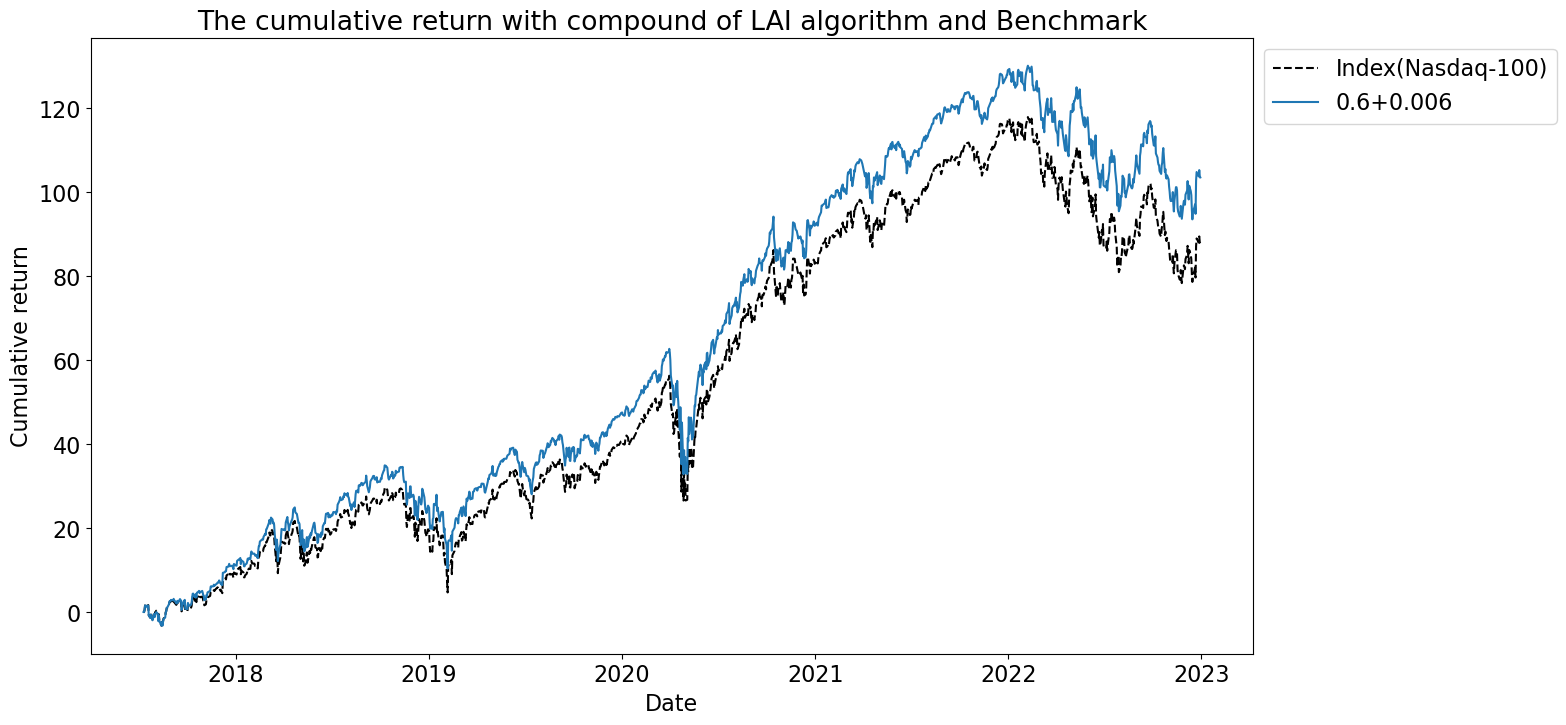

In [10]:
plt.figure(figsize=(15, 8))
indx = stock_idx[train_widnow + test_window-1:]
plt.plot(indx, np.cumsum(y_gt), '--', color='black', label = 'Index(Nasdaq-100)')

for key, val in y_est_dict.items():
    plt.plot(indx, np.cumsum(val), label=key)
plt.ylabel("Cumulative return")
plt.xlabel("Date")
plt.title("The cumulative return with compound of LAI algorithm and Benchmark")
plt.legend(bbox_to_anchor=(1.00, 1.0), loc='upper left')
plt.show()